# 1. Multiple regression model predictions

## 1.1 Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge  
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.svm import SVR  
from sklearn.neighbors import NearestNeighbors
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn import tree
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor,ExtraTreesRegressor,BaggingRegressor,StackingRegressor
from sklearn.ensemble import VotingRegressor,AdaBoostRegressor 
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb 
from sklearn.metrics import accuracy_score 
from sklearn import metrics
import warnings  
from sklearn.model_selection import train_test_split, GridSearchCV  
import os
# Ignore all warnings 
warnings.filterwarnings("ignore")  

## 1.2 Importing data

In [3]:
# Load the data
data = pd.read_excel('dataset.xlsx',index_col = 0)
data.fillna(0,inplace = True)
print(data.columns)
print(data.shape)

Index(['Training set value', 'HOMO (eV)', 'LUMO (eV)', 'DM', 'NVE', 'TPSA',
       'Mw', 'NHA', 'BertzCT', 'AMW',
       ...
       'MLOGP2', 'DLS_01', 'DLS_02', 'DLS_03', 'DLS_04', 'DLS_05', 'DLS_06',
       'DLS_cons', 'LLS_01', 'LLS_02'],
      dtype='object', length=631)
(210, 631)


In [4]:
def generate_non_consecutive_combinations(lst):  
    # auxiliary function that generates combinations and checks that the conditions are satisfied
    def backtrack(start, path, result):  
        if len(path) == 3:  # If three elements have been selected  
            result.append(list(path))  # Add to results list
            return  
        for i in range(start, len(lst)):  
            # Check if the new element is a duplicate of an element in path
            if all(lst[i] != p for p in path):  
                # Add a new element to the path and continue searching from the next element 
                backtrack(i + 1, path + [lst[i]], result)  
    result = []  
    # Search from the first element of the list
    backtrack(0, [], result)  
    # Remove combinations containing duplicate elements (theoretically not needed in this particular problem, since it's already checked by all())  
    # But for clarity and completeness, the comment for this step is retained here 
    # result = [c for c in result if len(set(c)) == len(c)]  
    dict_result = {}
    for item in result:
        name = f'{item[0][0]}_{item[1][0]}_{item[2][0]}'
        dict_result[name] = item
    return dict_result  

## 1.3 Data selection

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import SelectFromModel
import pandas as pd

X = data.drop(['Training set value'],axis=1).to_numpy()
print(X.shape)
y = data['Training set value'].to_numpy()
print(y.shape)

feats_names_df = pd.read_csv('selected_feats.csv')
selected_feats = feats_names_df['selected_feats'].to_list()
len(selected_feats)

(210, 630)
(210,)


80

## 1.4 Multi-regression evaluation

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge  
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.svm import SVR  
from sklearn.neighbors import NearestNeighbors
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn import tree
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor,ExtraTreesRegressor,BaggingRegressor,StackingRegressor
from sklearn.ensemble import VotingRegressor,AdaBoostRegressor 
from sklearn.preprocessing import PolynomialFeatures
import math
import xgboost as xgb

### Model
models = {  
    'LinearRegression': LinearRegression(),  
    'DecisionTreeRegressor':tree.DecisionTreeRegressor(),
    'SVR': SVR() ,
    'XGBRegressor': xgb.XGBRegressor(eval_metric='rmsle'),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, n_jobs=2), 
    'BaggingRegressor':BaggingRegressor(n_estimators=100, n_jobs=2),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),  
    'AdaBoostRegressor':AdaBoostRegressor(),
    'NearestNeighbors': KNeighborsRegressor(n_neighbors=3), 
    'ExtraTreesRegressor':ExtraTreesRegressor(n_estimators=100),   
}  
# Parameter tuning
param_grids = {  
    'LinearRegression': { 'fit_intercept': [True] },  
    'DecisionTreeRegressor':{'max_depth': [50],  # Maximum depth of tree
                              'min_samples_split': [5,],  # Minimum number of samples required to partition internal nodes 
                              'min_samples_leaf': [1]},  # Minimum number of samples a leaf node must have                     
    'RandomForestRegressor': {'n_estimators': [2000],  # Number of trees
                               'max_depth': [7],  # Maximum depth of tree 
                               'min_samples_split': [2],  # Minimum number of samples required to partition internal nodes
                               'min_samples_leaf': [4]},  # Minimum number of samples a leaf node must have
    'ExtraTreesRegressor':{'n_estimators': [500],'min_samples_leaf':[3]},   # Minimum number of samples a leaf node must have
    'BaggingRegressor': {'n_estimators': [1000,]},
    'GradientBoostingRegressor': {    'n_estimators': [50],  # Maximum number of iterations for weak learners
                                       'learning_rate': [0.09],    
                                       'max_depth': [7],  # Maximum depth of a single regression tree
                                       'subsample': [0.8],  # Proportion of samples used to fit each base learner
                                       'min_samples_split': [4],  # Minimum number of samples required to delineate internal nodes
                                       'min_samples_leaf': [3],  # Minimum number of samples a leaf node must have
                                       'max_features': [None]},    
    'AdaBoostRegressor':{  'n_estimators': [100],  
                             'learning_rate': [0.5]}, 
    'NearestNeighbors': {'n_neighbors': [3],   
                             'p': [1]},  
    'SVR': { 'C': [10],  
             'kernel': ['rbf'],  
             'gamma': ['auto'] } ,
    'XGBRegressor':{ 'n_estimators': [200],  
                      'learning_rate': [0.01 ],  
                      'max_depth': [3],  
                      'subsample': [0.8],  
                      'colsample_bytree': [0.8],  
                      'use_label_encoder': [False],  
                      'eval_metric': ['mlogloss']},
}  

def cv_model(X, Y, epochs, kfolds, models,param_grids ):
    """
    """
    print('dataset shape:',X.shape, Y.shape)
    result_res = pd.DataFrame(columns = ['model','train_r2','train_mae','train_rmse','test_r2','test_mae','test_rmse']) 
    for idx in range(epochs):
        # ----
        # Initialize variables for evaluation metrics for Model 1
        # Define the number of folds for cross-validation
        num_folds = kfolds
        kf_train = KFold(n_splits=num_folds, shuffle=True)
        best_models = []
        for name, model in models.items(): 
            print(f'model name is {name}')
            grid_search = GridSearchCV(model, param_grids[name], cv = kfolds, scoring='r2')  
            r_squared_values_train = []
            mae_values_train = []
            rmse_values_train = []
            r_squared_values_test = []
            mae_values_test = []
            rmse_values_test = []
            # Perform cross-validation for the first model
            for train_in_index, test_in_index in kf_train.split(X):
                X_train_in, X_test_in = X[train_in_index], X[test_in_index]
                Y_train_in, Y_test_in = Y[train_in_index], Y[test_in_index]
                # Train the first model
                grid_search.fit(X_train_in, Y_train_in)
                # Make predictions on the test set for the first model
                Y_pred_test_in = grid_search.predict(X_test_in)
                Y_pred_train_in = grid_search.predict(X_train_in)
                # Calculate evaluation metrics for the training set
                r_squared_train = r2_score(Y_train_in, Y_pred_train_in)
                mae_train = mean_absolute_error(Y_train_in, Y_pred_train_in)
                rmse_train = math.sqrt(mean_squared_error(Y_train_in, Y_pred_train_in))
                # Calculate evaluation metrics for the test set
                r_squared_test = r2_score(Y_test_in, Y_pred_test_in)
                mae_test = mean_absolute_error(Y_test_in, Y_pred_test_in)
                rmse_test = math.sqrt(mean_squared_error(Y_test_in, Y_pred_test_in))
                # Append evaluation metrics to lists for the first model
                r_squared_values_train.append(r_squared_train)
                mae_values_train.append(mae_train)
                rmse_values_train.append(rmse_train)
                r_squared_values_test.append(r_squared_test)
                mae_values_test.append(mae_test)
                rmse_values_test.append(rmse_test)
            # Calculate and print the average evaluation metrics over all folds for the first model
            best_models.append((name, grid_search.best_estimator_))
            print(grid_search.best_estimator_)
            avg_r_squared_train = np.mean(r_squared_values_train)
            avg_mae_train = np.mean(mae_values_train)
            avg_rmse_train = np.mean(rmse_values_train)
            avg_r_squared_test = np.mean(r_squared_values_test)
            avg_mae_test = np.mean(mae_values_test)
            avg_rmse_test = np.mean(rmse_values_test)
            print(avg_r_squared_train, avg_mae_train, avg_rmse_train,avg_r_squared_test,avg_mae_test,avg_rmse_test )
            result_res.loc[len(result_res)] = [name,avg_r_squared_train, avg_mae_train, avg_rmse_train,avg_r_squared_test,avg_mae_test,avg_rmse_test ]
        ###############
    return result_res

epochs = 5
kfolds = 5
result_res = cv_model(data[selected_feats].values, y, epochs, kfolds, models,param_grids )
result_res

dataset shape: (210, 80) (210,)
model name is LinearRegression
LinearRegression()
0.9505786286293189 2.4424566354949495 3.1693765784885337 0.6561857891652719 5.587893895307175 8.160710286123926
model name is DecisionTreeRegressor
DecisionTreeRegressor(max_depth=50, min_samples_split=5)
0.9905634487041661 0.8189285714285715 1.3780019549608082 0.5872720163223468 6.184126984126985 9.096640590846874
model name is SVR
SVR(C=10, gamma='auto')
0.8386275771764853 2.7205950388494466 5.727821267602138 0.47761746083667633 7.098368804414756 10.283372514667802
model name is XGBRegressor
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mlogloss',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01,

,model,train_r2,train_mae,train_rmse,test_r2,test_mae,test_rmse
0,LinearRegression,0.950579,2.442457,3.169377,0.656186,5.587894,8.160710
1,DecisionTreeRegressor,0.990563,0.818929,1.378002,0.587272,6.184127,9.096641
2,SVR,0.838628,2.720595,5.727821,0.477617,7.098369,10.283373
3,XGBRegressor,0.886804,3.568710,4.795974,0.668822,5.891033,8.109200
4,RandomForestRegressor,0.924395,2.714774,3.913285,0.739409,5.129186,7.055435
5,BaggingRegressor,0.967462,1.800138,2.570951,0.777103,4.827723,6.676143
6,GradientBoostingRegressor,0.998349,0.381267,0.575690,0.753054,4.792620,6.864198
7,AdaBoostRegressor,0.930542,3.169767,3.751431,0.782411,4.917183,6.421933
8,NearestNeighbors,0.880861,3.203889,4.912102,0.672380,5.165079,7.943592
9,ExtraTreesRegressor,0.978160,1.381190,2.099974,0.815626,4.198444,6.045639


In [8]:
result_res_single = result_res
result_res_single.to_csv('result_res_single.csv')

# 2. Stacking Model

In [66]:
import shap
import math
shap.initjs()
param_grids = {  
    'LinearRegression': { 'fit_intercept': [True] },  
    'ExtraTreesRegressor':  {'n_estimators': [500],'min_samples_leaf':[3],},   
    'GradientBoostingRegressor': {    'n_estimators': [50],  # Maximum number of iterations for weak learners
                                       'learning_rate': [0.09],    
                                       'max_depth': [7],  # Maximum depth of a single regression tree  
                                       'subsample': [0.8],  # Proportion of samples used to fit each base learner
                                       'min_samples_split': [4],  # Minimum number of samples required to delineate internal nodes
                                       'min_samples_leaf': [3],  # Minimum number of samples a leaf node must have
                                       'max_features': [None]},  

}  
models = {  
    'LinearRegression': LinearRegression(),
    'GradientBoostingRegressor': GradientBoostingRegressor() ,
    'ExtraTreesRegressor':ExtraTreesRegressor(n_estimators=100,n_jobs = -1),   
}  
def get_three_base_models(models):
    three_base_models = {}
    three_base_models[f'LinearRegression_GradientBoostingRegressor_ExtraTreesRegressor'] = [('LinearRegression', LinearRegression()),
                                                                              ('GradientBoostingRegressor', GradientBoostingRegressor() ),
                                                                              ('ExtraTreesRegressor', ExtraTreesRegressor(n_estimators=100,n_jobs = -1))]
    return three_base_models
    
def cv_model_x(X, Y, epochs, kfolds, models,param_grids ):

    result_res = pd.DataFrame(columns = ['model','train_r2','train_mae','train_rmse','test_r2','test_mae','test_rmse'])  
    
    for idx in range(epochs):
        # Initialize variables for evaluation metrics for Model 1
        # Define the number of folds for cross-validation
        num_folds = kfolds
        kf_train = KFold(n_splits=num_folds, shuffle=True)
        best_models = {}
        df_train = pd.DataFrame()
        df_valid = pd.DataFrame()
        for name, model in models.items(): 
            train_pred = []
            train_true = []
            valid_pred = []
            valid_true = []
            print(f'model name is {name}')
            grid_search = GridSearchCV(model, param_grids[name], cv = kfolds, scoring='r2')  
            r_squared_values_train = []
            mae_values_train = []
            rmse_values_train = []
            r_squared_values_test = []
            mae_values_test = []
            rmse_values_test = []
            # Perform cross-validation for the first model
            for train_in_index, test_in_index in kf_train.split(X):
                X_train_in, X_test_in = X[train_in_index], X[test_in_index]
                Y_train_in, Y_test_in = Y[train_in_index], Y[test_in_index]
                # Train the first model
                grid_search.fit(X_train_in, Y_train_in)
                # Make predictions on the test set for the first model
                Y_pred_test_in = grid_search.predict(X_test_in)
                Y_pred_train_in = grid_search.predict(X_train_in)
                ########
                train_true += list(Y_train_in)
                train_pred += list(Y_pred_train_in)
                valid_true += list(Y_test_in)
                valid_pred += list(Y_pred_test_in)
                # Calculate evaluation metrics for the training set
                r_squared_train = r2_score(Y_train_in, Y_pred_train_in)
                mae_train = mean_absolute_error(Y_train_in, Y_pred_train_in)
                rmse_train = math.sqrt(mean_squared_error(Y_train_in, Y_pred_train_in))
                # Calculate evaluation metrics for the test set
                r_squared_test = r2_score(Y_test_in, Y_pred_test_in)
                mae_test = mean_absolute_error(Y_test_in, Y_pred_test_in)
                rmse_test = math.sqrt(mean_squared_error(Y_test_in, Y_pred_test_in))
                # Append evaluation metrics to lists for the first model
                r_squared_values_train.append(r_squared_train)
                mae_values_train.append(mae_train)
                rmse_values_train.append(rmse_train)
                r_squared_values_test.append(r_squared_test)
                mae_values_test.append(mae_test)
                rmse_values_test.append(rmse_test)
            # Calculate and print the average evaluation metrics over all folds for the first model
            best_models[name] = grid_search.best_estimator_
            avg_r_squared_train = np.mean(r_squared_values_train)
            avg_mae_train = np.mean(mae_values_train)
            avg_rmse_train = np.mean(rmse_values_train)
            avg_r_squared_test = np.mean(r_squared_values_test)
            avg_mae_test = np.mean(mae_values_test)
            avg_rmse_test = np.mean(rmse_values_test)
            print(avg_r_squared_train, avg_mae_train, avg_rmse_train,avg_r_squared_test,avg_mae_test,avg_rmse_test )
            df_train[f'{name}_train_true'] = train_true
            df_train[f'{name}_train_pred'] = train_pred
            df_valid[f'{name}_valid_true'] = valid_true
            df_valid[f'{name}_valid_pred'] = valid_pred
   
        three_base_models = get_three_base_models(best_models)   
        ## Define the metamodel
        from sklearn.linear_model import RidgeCV
        final_estimator = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1,5,10]) 
        train_pred = []
        train_true = []
        valid_pred = []
        valid_true = [] 
        for name, base_models in three_base_models.items():  
            print(f'model name is {name}')
            # # Create a stacking_regressor 
            stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=final_estimator, cv=5,n_jobs=-1) 
           
            r_squared_values_train = []
            mae_values_train = []
            rmse_values_train = []
            r_squared_values_test = []
            mae_values_test = []
            rmse_values_test = []
            # Perform cross-validation for the first model
            for train_in_index, test_in_index in kf_train.split(X):
                X_train_in, X_test_in = X[train_in_index], X[test_in_index]
                Y_train_in, Y_test_in = Y[train_in_index], Y[test_in_index]
                # Train the first model
                stacking_regressor.fit(X_train_in, Y_train_in)
                # Make predictions on the test set for the first model
                Y_pred_test_in = stacking_regressor.predict(X_test_in)
                Y_pred_train_in = stacking_regressor.predict(X_train_in)
                train_true += list(Y_train_in)
                train_pred += list(Y_pred_train_in)
                valid_true += list(Y_test_in)
                valid_pred += list(Y_pred_test_in)
                # Calculate evaluation metrics for the training set
                r_squared_train = r2_score(Y_train_in, Y_pred_train_in)
                mae_train = mean_absolute_error(Y_train_in, Y_pred_train_in)
                rmse_train = math.sqrt(mean_squared_error(Y_train_in, Y_pred_train_in))
                # Calculate evaluation metrics for the test set
                r_squared_test = r2_score(Y_test_in, Y_pred_test_in)
                mae_test = mean_absolute_error(Y_test_in, Y_pred_test_in)
                rmse_test = math.sqrt(mean_squared_error(Y_test_in, Y_pred_test_in))
                # Append evaluation metrics to lists for the first model
                r_squared_values_train.append(r_squared_train)
                mae_values_train.append(mae_train)
                rmse_values_train.append(rmse_train)
                r_squared_values_test.append(r_squared_test)
                mae_values_test.append(mae_test)
                rmse_values_test.append(rmse_test)
            avg_r_squared_train = np.mean(r_squared_values_train)
            avg_mae_train = np.mean(mae_values_train)
            avg_rmse_train = np.mean(rmse_values_train)
            avg_r_squared_test = np.mean(r_squared_values_test)
            avg_mae_test = np.mean(mae_values_test)
            avg_rmse_test = np.mean(rmse_values_test)
            print(avg_r_squared_train, avg_mae_train, avg_rmse_train,avg_r_squared_test,avg_mae_test,avg_rmse_test )
            df_train[f'{name}_train_true'] = train_true
            df_train[f'{name}_train_pred'] = train_pred
            df_valid[f'{name}_valid_true'] = valid_true
            df_valid[f'{name}_valid_pred'] = valid_pred
            result_res.loc[len(result_res)] = [name,avg_r_squared_train, avg_mae_train, avg_rmse_train,avg_r_squared_test,avg_mae_test,avg_rmse_test ]
            result_res.to_csv('./scatter_plot/result_res_LinearRegression_GradientBoostingRegressor_ExtraTreesRegressor_scatter_plot.csv')
    return result_res,df_train, df_valid


epochs = 1
kfolds = 5
print(data[selected_feats].values.shape)
for idx in range(100):
    print(f'...........................{idx}...............................')
    result_res, df_train, df_valid = cv_model_x(data[selected_feats].values, y, epochs, kfolds, models,param_grids)
    df_train.to_csv(f'./scatter_plot/final_train_best_{idx}.csv')
    df_valid.to_csv(f'./scatter_plot/final_valid_best_{idx}.csv')

(210, 80)
...........................0...............................
model name is LinearRegression
0.9531365188152444 2.364692138518323 3.0841694695426134 0.4349283788847371 6.568751729265574 9.604472793113178
model name is GradientBoostingRegressor
0.9980464677758146 0.40757945313286204 0.6204514512464382 0.771492527875042 4.751655306891503 6.645644154429367
model name is ExtraTreesRegressor
0.9790468623903837 1.3596665634920637 2.0585262162009514 0.8361353296267469 4.108707619047618 5.709856103896272
model name is LinearRegression_GradientBoostingRegressor_ExtraTreesRegressor
0.9963711449483178 0.6539723948880025 0.8049775008123554 0.8101661536376416 3.814673410793995 5.620437764358643
...........................1...............................
model name is LinearRegression
0.9510656316358832 2.448424531013642 3.1459807328191087 0.2933456154812791 6.446976416607067 9.867842317099392
model name is GradientBoostingRegressor
0.9978036359013206 0.3983006134502191 0.6277824985873615 0.

# 3. Metrics

## 3.1 Model parameters

In [9]:
param_grids = {  
    'LinearRegression': {  'fit_intercept': [True] },  
    'DecisionTreeRegressor':{'max_depth': [50],  # Maximum depth of tree  
                              'min_samples_split': [5,],  # Minimum number of samples required to partition internal nodes
                              'min_samples_leaf': [1]},  # Minimum number of samples a leaf node must have   
    'RandomForestRegressor': {'n_estimators': [2000],  # Number of trees  
                               'max_depth': [7],  # Maximum depth of the tree   
                               'min_samples_split': [2],  # Minimum number of samples required to partition internal nodes  
                               'min_samples_leaf': [4]},  # Minimum number of samples a leaf node must have  
    'ExtraTreesRegressor':{'n_estimators': [ 500],'min_samples_leaf':[3]},  # Minimum number of samples a leaf node must have 
    'BaggingRegressor': {'n_estimators': [1000,]},
    'GradientBoostingRegressor': {    'n_estimators': [50],  # Maximum number of iterations for weak learners 
                                       'learning_rate': [0.09],  # learning rate
                                       'max_depth': [7],  # Maximum depth of a single regression tree 
                                       'subsample': [0.8],  # Proportion of samples used to fit each base learner    
                                       'min_samples_split': [4],  # Minimum number of samples required to partition internal nodes   
                                       'min_samples_leaf': [3],  # Minimum number of samples a leaf node must have 
                                       'max_features': [None]},  # Number of features to consider when finding the optimal segmentation
    'AdaBoostRegressor':{  'n_estimators': [100],  
                             'learning_rate': [0.5]},  
    'NearestNeighbors': {'n_neighbors': [3],   
                             'p': [1]}, 
    'SVR': { 'C': [10],  
             'kernel': ['rbf'],  
             'gamma': ['auto'] } ,
    'XGBRegressor':{ 'n_estimators': [200],  
                      'learning_rate': [0.01],  
                      'max_depth': [3],  
                      'subsample': [0.8],  
                      'colsample_bytree': [0.8],  
                      'use_label_encoder': [False],  
                      'eval_metric': ['mlogloss']},
} 

## 3.2 Feature importance

In [10]:
param_grids = {  
    'DecisionTreeRegressor':{'max_depth': 50,  # Maximum depth of the tree  
                              'min_samples_split': 5,  # Minimum number of samples required to partition internal nodes
                              'min_samples_leaf': 1},  # Minimum number of samples a leaf node must have                       
    'RandomForestRegressor': {'n_estimators': 2000,  # Number of trees  
                               'max_depth': 7,  # Maximum depth of the tree  
                               'min_samples_split': 2,  # Minimum number of samples required to partition internal nodes   
                               'min_samples_leaf': 4},  # Minimum number of samples a leaf node must have
    'ExtraTreesRegressor':{'n_estimators':  500,'min_samples_leaf':3},  # Minimum number of samples a leaf node must have  
    'GradientBoostingRegressor': {    'n_estimators': 50,  # Maximum number of iterations for weak learners  
                                       'learning_rate': 0.09,  # learning rate    
                                       'max_depth': 7,  # Maximum depth of a single regression tree 
                                       'subsample': 0.8,  # Proportion of samples used to fit each base learner  
                                       'min_samples_split': 4,  # Minimum number of samples required to partition internal nodes
                                       'min_samples_leaf': 3,  # Minimum number of samples a leaf node must have 
                                       'max_features': None},  # The number of features to be considered in finding the optimal segmentation  
     'AdaBoostRegressor':{  'n_estimators': 100,  
                             'learning_rate': 0.5}, 
  
    'XGBRegressor':{ 'n_estimators': 200,  
                      'learning_rate': 0.01 ,  
                      'max_depth': 3,  
                      'subsample': 0.8,  
                      'colsample_bytree': 0.8,  
                      'use_label_encoder': False,  
                      'eval_metric': 'mlogloss'},
} 

feat_importance_models = [('DecisionTreeRegressor',DecisionTreeRegressor()),
                          ('RandomForestRegressor', RandomForestRegressor(n_estimators=1000, n_jobs=2)), 
                         ('XGBRegressor', xgb.XGBRegressor(eval_metric='rmsle')),
                          ('ExtraTreesRegressor',ExtraTreesRegressor(n_estimators=1000)),
                          ('GradientBoostingRegressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)),
                          ('AdaBoostRegressor',AdaBoostRegressor()) ]

df = pd.DataFrame()
for model_name, model in feat_importance_models: 

    model.set_params(**param_grids[model_name])
    model.fit(data[selected_feats].values, y)
    feature_importance = model.feature_importances_
    #######
    feat_importances = pd.Series(feature_importance, index = selected_feats).sort_values(ascending = False)

    fi = list(feat_importances.index)
    df[model_name] = fi 

df.to_csv('model_features_importance.csv')   

# 4. Stacking results

In [82]:
import pandas as pd 
import math

methods_list = [('LinearRegression_valid_true', 'LinearRegression_valid_pred'),
       ('GradientBoostingRegressor_valid_true',
       'GradientBoostingRegressor_valid_pred'),
       ('ExtraTreesRegressor_valid_true', 'ExtraTreesRegressor_valid_pred'),
       ('LinearRegression_GradientBoostingRegressor_ExtraTreesRegressor_valid_true',
       'LinearRegression_GradientBoostingRegressor_ExtraTreesRegressor_valid_pred')]
max_index = 0
max_r2 = 0
for i in range(100):
    dataset = pd.read_csv(f'./scatter_plot/final_valid_best_{i}.csv',index_col = 0)
    r2 = r2_score(dataset['LinearRegression_GradientBoostingRegressor_ExtraTreesRegressor_valid_true'], dataset['LinearRegression_GradientBoostingRegressor_ExtraTreesRegressor_valid_pred'])
    if r2 > max_r2:
        max_r2 = r2
        max_index = i
print('max_r2:, max_index:',max_r2,max_index)

max_r2:, max_index: 0.8793921887548204 46


In [83]:
max_index = 46 ### Enter the value of max_index
metrics_dict = {'model':[], 'r2_train':[], 'r2_test':[], 'mae_train':[], 'mae_test':[], 'rmse_train':[], 'rmse_test':[]}
for i in range(max_index,max_index+1):

    dataset_test = pd.read_csv(f'./scatter_plot/final_valid_best_{i}.csv',index_col = 0)
    dataset_train = pd.read_csv(f'./scatter_plot/final_train_best_{i}.csv',index_col = 0)
    for idx, (true, pred) in enumerate(methods_list):
        r2_test = r2_score(dataset_test[true], dataset_test[pred])
        mae_test = mean_absolute_error(dataset_test[true], dataset_test[pred])
        rmse_test = math.sqrt(mean_squared_error(dataset_test[true], dataset_test[pred]))
        
        true_train = true.replace("valid", "train")
        pred_train = pred.replace("valid", "train")
        r2_train = r2_score(dataset_train[true_train], dataset_train[pred_train])
        mae_train = mean_absolute_error(dataset_train[true_train], dataset_train[pred_train])
        rmse_train = math.sqrt(mean_squared_error(dataset_train[true_train], dataset_train[pred_train]))
        
        if idx==3:
            model = 'Stacking'
        else:
            model = pred.split('_')[0]
        metrics_dict['model'].append(model)
        metrics_dict['r2_train'].append(r2_train)
        metrics_dict['mae_train'].append(mae_train)
        metrics_dict['rmse_train'].append(rmse_train)
        
        metrics_dict['r2_test'].append(r2_test)
        metrics_dict['mae_test'].append(mae_test)
        metrics_dict['rmse_test'].append(rmse_test)
        
metrics_df = pd.DataFrame.from_dict(metrics_dict)
metrics_df.to_csv('best_results_r2_mae_rmse.csv')
metrics_df

,model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test
0,LinearRegression,0.950966,0.682766,2.437229,5.814130,3.159537,8.036444
1,GradientBoostingRegressor,0.998136,0.769472,0.373575,4.771209,0.615977,6.850704
2,ExtraTreesRegressor,0.978973,0.837572,1.371514,4.097078,2.068999,5.750483
3,Stacking,0.995777,0.879392,0.742858,3.631681,0.927252,4.955203


## 4.1 Scatter plot

In [84]:
import matplotlib.pyplot as plt  
import numpy as np  
  
# X is the independent variable and Y is the dependent variable  
X = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  
Y = np.array([2.1, 2.9, 3.8, 4.6, 5.5, 6.3, 7.2, 8.1, 9.0, 10.0])  

def scatter_plot(y_train_true, y_train_pred, y_test_true, y_test_pred, color, name):
    # Create a graphic object and an axis object
    fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
    # Scatter plotting
    ax.scatter(y_train_true, y_train_pred, color=color, label='Train Points')  
    ax.scatter(y_test_true, y_test_pred, color='gray', label='Test Points')  
    # Add titles and tags 
    # ax.set_title('Scatter Plot of Regression Problem')  
    ax.set_xlabel('Experimental DN (kcal/mol)')  
    ax.set_ylabel('Predicted DN (kcal/mol)')  
    # Add gridlines
    ax.grid(False)  
    # Add legend
    ax.legend()  
    # Display graphics
    plt.show()   
    # If you need to save the graphic as a file, you can use the following code 
    fig.savefig(f'regression_scatter_plot_{name}.png', dpi=300)

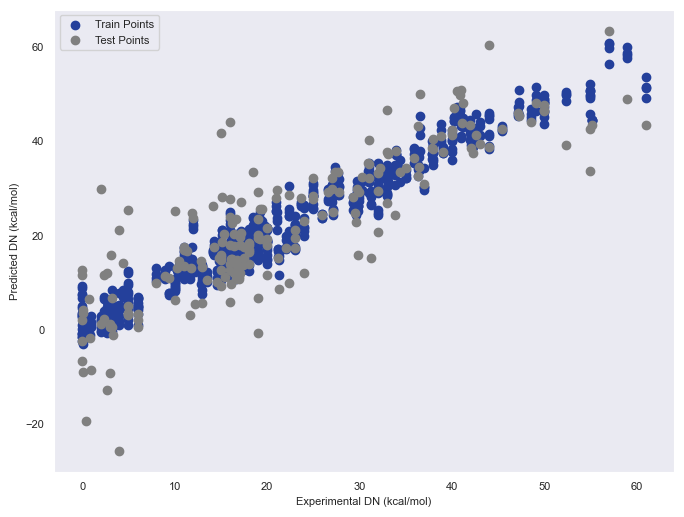

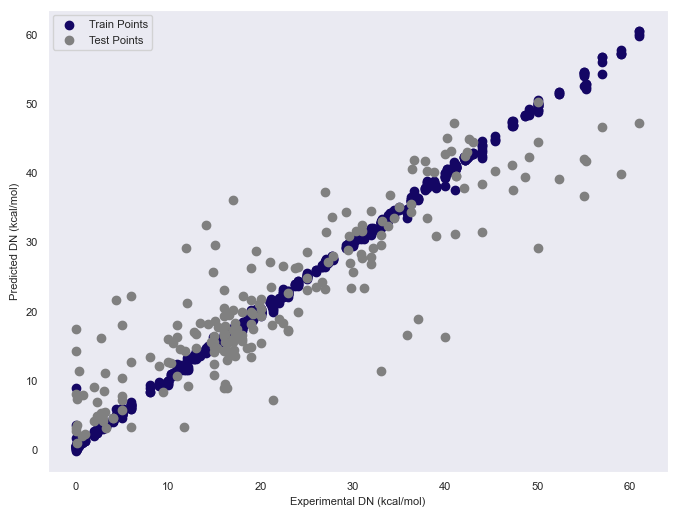

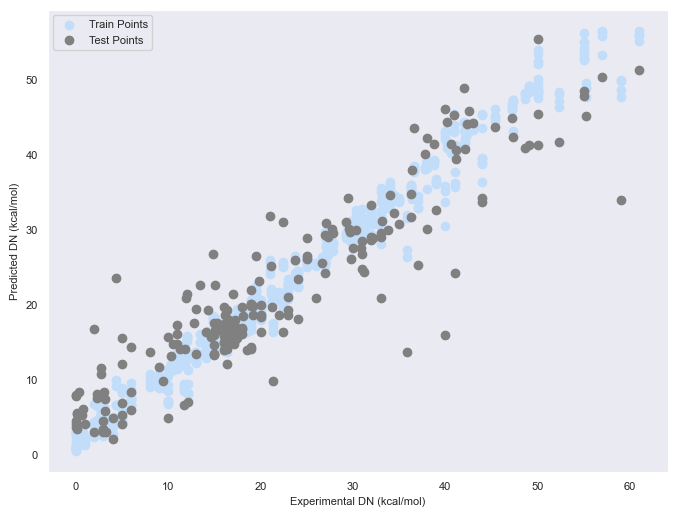

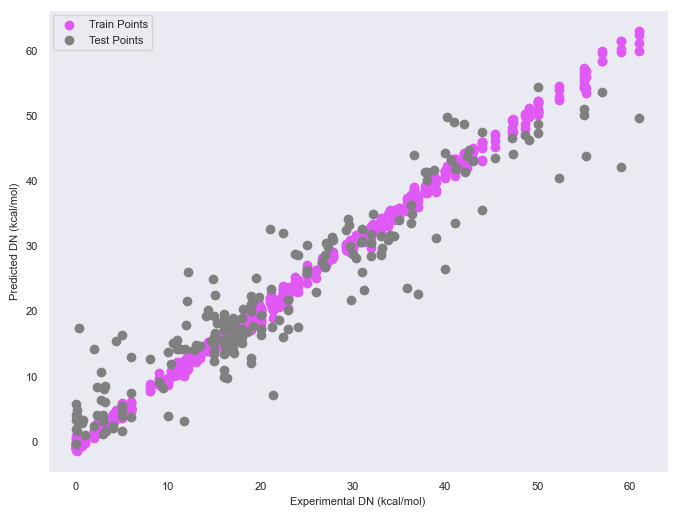

,model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test
0,LinearRegression,0.950966,0.682766,2.437229,5.814130,3.159537,8.036444
1,GradientBoostingRegressor,0.998136,0.769472,0.373575,4.771209,0.615977,6.850704
2,ExtraTreesRegressor,0.978973,0.837572,1.371514,4.097078,2.068999,5.750483
3,Stacking,0.995777,0.879392,0.742858,3.631681,0.927252,4.955203


In [85]:
import pandas as pd
max_index = 46 ### Enter the value of max_index

metrics_dict = {'model':[], 'r2_train':[], 'r2_test':[], 'mae_train':[], 'mae_test':[], 'rmse_train':[], 'rmse_test':[]}
for i in range(max_index,max_index+1):

    dataset_test = pd.read_csv(f'./scatter_plot/final_valid_best_{i}.csv',index_col = 0)
    dataset_train = pd.read_csv(f'./scatter_plot/final_train_best_{i}.csv',index_col = 0)
    for idx, (true, pred) in enumerate(methods_list):
        r2_test = r2_score(dataset_test[true], dataset_test[pred])
        mae_test = mean_absolute_error(dataset_test[true], dataset_test[pred])
        rmse_test = math.sqrt(mean_squared_error(dataset_test[true], dataset_test[pred]))
        
        true_train = true.replace("valid", "train")
        pred_train = pred.replace("valid", "train")
        r2_train = r2_score(dataset_train[true_train], dataset_train[pred_train])
        mae_train = mean_absolute_error(dataset_train[true_train], dataset_train[pred_train])
        rmse_train = math.sqrt(mean_squared_error(dataset_train[true_train], dataset_train[pred_train]))
        
        if idx==3:
            model = 'Stacking'
        else:
            model = pred.split('_')[0]
        metrics_dict['model'].append(model)
        metrics_dict['r2_train'].append(r2_train)
        metrics_dict['mae_train'].append(mae_train)
        metrics_dict['rmse_train'].append(rmse_train)
        
        metrics_dict['r2_test'].append(r2_test)
        metrics_dict['mae_test'].append(mae_test)
        metrics_dict['rmse_test'].append(rmse_test)

        name = model
        y_train_true = dataset_train[true_train]
        y_train_pred = dataset_train[pred_train]
        y_test_true = dataset_test[true]
        y_test_pred =  dataset_test[pred]
        colors = (np.random.rand(),np.random.rand(),np.random.rand())

        scatter_plot(y_train_true, y_train_pred, y_test_true, y_test_pred,colors, name)
   
metrics_df = pd.DataFrame.from_dict(metrics_dict)
metrics_df.to_csv('best_results_r2_mae_rmse.csv')
metrics_df

# 5. Single model's metrics 

In [11]:
import pandas as pd

data = pd.read_csv('result_res_single.csv',index_col = 0)
print(data.columns)
grouped = data.groupby('model')[['train_r2', 'train_mae', 'train_rmse', 'test_r2', 'test_mae',
       'test_rmse']].mean()  
grouped.to_csv('single_model_mean_metrics.csv')
grouped

Index(['model', 'train_r2', 'train_mae', 'train_rmse', 'test_r2', 'test_mae',
       'test_rmse'],
      dtype='object')


,train_r2,train_mae,train_rmse,test_r2,test_mae,test_rmse
model,,,,,,
AdaBoostRegressor,0.929946,3.162039,3.766547,0.765112,4.973032,6.670262
BaggingRegressor,0.967374,1.804384,2.572678,0.770946,4.847381,6.684856
DecisionTreeRegressor,0.991553,0.766468,1.300634,0.529257,6.348603,9.507921
ExtraTreesRegressor,0.978855,1.372955,2.067675,0.777512,4.452082,6.481923
GradientBoostingRegressor,0.998367,0.378350,0.569855,0.769422,4.675553,6.669457
LinearRegression,0.950602,2.434205,3.165214,0.607745,5.748068,8.436408
NearestNeighbors,0.875207,3.278468,5.030712,0.704329,5.064571,7.597637
RandomForestRegressor,0.925256,2.698139,3.893786,0.731293,5.206332,7.226935
SVR,0.839608,2.693541,5.707204,0.440451,7.312219,10.482821


# 6. SHAP Values
## - Open and run the "Shap_value_calculation.ipynb" file, then continue

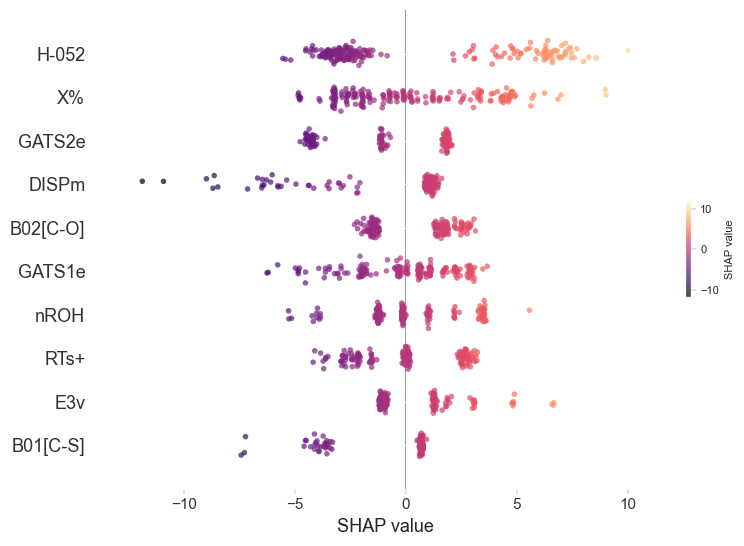

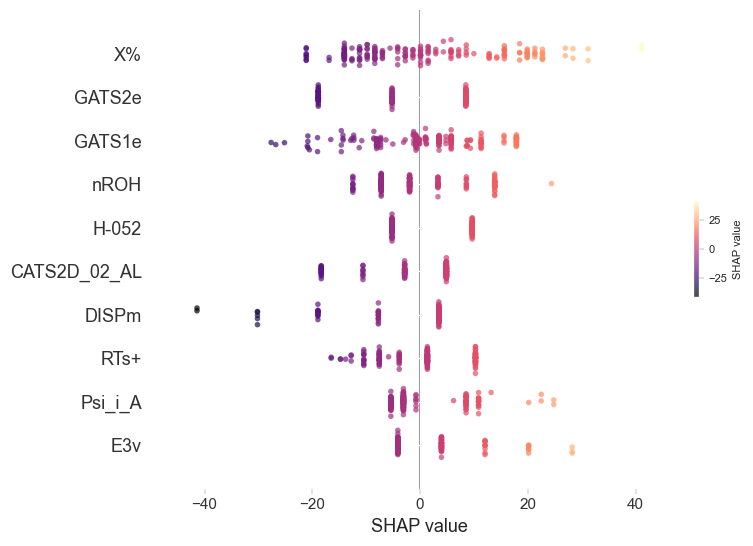

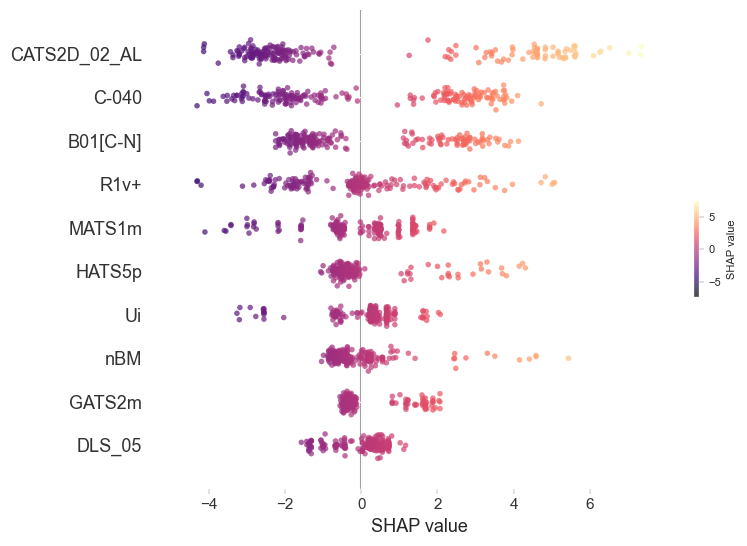

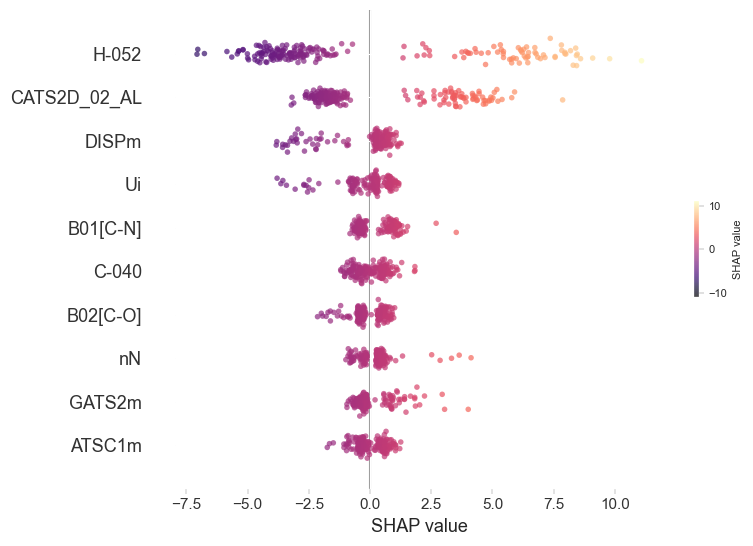

In [87]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np

for file in ['shap_values_LinearRegression_GradientBoostingRegressor_ExtraTreesRegressor.csv','shap_values_LinearRegression.csv',
             'shap_values_GradientBoostingRegressor.csv','shap_values_ExtraTreesRegressor.csv']:
    # Read CSV files
    shap_values = pd.read_csv(file)  # If the CSV file has no columns, set header=None
    
    # Specify feature name
    feature_names = ['B01[C-N]', 'DLS_cons', 'DLS_05', 'nX', 'B01[C-O]', 'TPSA(Tot)', 'nHM', 'nHet',
                     'Ui', 'nN', 'X%', 'LLS_02', 'nBM', 'LUMO', 'Me', 'nHDon', 'nHAcc', 'DLS_04',
                     'B03[C-N]', 'DISPv', 'ATSC1m', 'HOMO', 'O%', 'DISPp', 'R1v+', 'Chi_G/D', 'AAC',
                     'R1p+', 'GATS1p', 'HATSs', 'HATS5p', 'NdssC', 'Mor29m', 'H-049', 'RDF020p',
                     'DISPe', 'Hy', 'C-011', 'N%', 'R1e', 'DISPm', 'MATS1m', 'B05[C-O]', 'RTs+',
                     'E1m', 'C-040', 'TPSA', 'GATS1m', 'GATS1v', 'RDF020u', 'GATS1e', 'nO', 'nCt',
                     'RTv+', 'nRSR', 'SIC1', 'F02[C-O]', 'Mor07m', 'B02[C-O]', 'RARS', 'H-052',
                     'Psi_i_A', 'R4u', 'GATS2e', 'AMW', 'F01[C-O]', 'Mor12m', 'Mor27m',
                     'CATS2D_02_AL', 'CATS2D_03_DL', 'nTB', 'DM', 'GATS2m', 'TDB03m', 'E3v',
                     'CIC2', 'nROH', 'VR2_RG', 'CATS2D_02_DL', 'B01[C-S]']
    
    # Set the column names of the DataFrame
    shap_values.columns = feature_names
    
    # Convert data to numeric types, set to NaN if conversion is not possible
    shap_values = shap_values.apply(pd.to_numeric, errors='coerce')
    
    # Remove lines containing NaN
    shap_values.dropna(inplace=True)
    
    # Convert DataFrame to NumPy array
    shap_values_array = shap_values.values
    
   # Set the font size to 8
    plt.rcParams.update({'font.size': 8})
    
    # Calculate the average absolute SHAP value for each feature
    mean_shap_values = np.abs(shap_values_array).mean(axis=0)
    
    # Get the features in rank order, from highest to lowest importance
    feature_order = np.argsort(mean_shap_values)[::-1]
    
    # **Only the first 10 features**
    top_n = 10
    feature_order = feature_order[:top_n]
    
    # Sort and filter SHAP values and feature names
    shap_values_array = shap_values_array[:, feature_order]
    feature_names_ordered = [feature_names[i] for i in feature_order]
    
    # Update the number of features to the first 10
    num_features = top_n
    
    # Create a swarm map, show the first 10 features, set the background to transparent
    plt.figure(figsize=(10, num_features * 0.5), facecolor='none')  #  Adjusting Graphic Height
    
    # Mapping bee colonies
    shap.summary_plot(
        shap_values_array,
        feature_names=feature_names_ordered,
        plot_type='dot',
        max_display=num_features,
        sort=False,  #  We've manually sorted
        show=False,
        color_bar=False  # Hide the default color bar
    )
    
    # Get current axis
    ax = plt.gca()
    
    # Set the background of the axis to transparent
    ax.set_facecolor('none')
    
    # Clear the default scatterplot
    for coll in ax.collections:
        coll.remove()
    
    # Maximum absolute SHAP value for color mapping
    max_abs_shap = np.abs(shap_values_array).max()
    
    # Manually plot a scatter plot for each feature and save the last scatter object
    for i in range(num_features):
        # Get the SHAP value of the ith feature
        feature_shap_values = shap_values_array[:, i]
        # Position on the y-axis
        y = np.random.normal(i, 0.1, size=feature_shap_values.shape[0])
        # Color mapping to SHAP values
        colors = feature_shap_values
        scatter = ax.scatter(
            feature_shap_values,
            y,
            c=colors,
            cmap='magma',  # Use the specified color mapping
            vmin=-max_abs_shap,
            vmax=max_abs_shap,
            s=16,
            alpha=0.7,
            edgecolors='none'
        )
    
    # Add a color bar, using the last scatter object and adjusting the width of the color bar
    cbar = plt.colorbar(scatter, ax=ax, label='SHAP value', shrink=0.2)
    
    # Adjust color bar border line width to 0.2
    cbar.outline.set_linewidth(0.2)
    
    # Adjusting the width of the color bar scale to 0.2
    cbar.ax.tick_params(width=0.2)
    
    # Set the color bar background to transparent
    cbar.ax.set_facecolor('none')
    
    # Setting the y-axis scale and labels
    plt.yticks(range(num_features), feature_names_ordered)
     
    # Setting the x-axis label
    plt.xlabel('SHAP value')
    
    # Adjust the line width of the axes to 0.2
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.2)
    
    # Adjusting the width of the scale to 0.2
    ax.tick_params(width=0.2)
    
    # Invert the y-axis so that the features are arranged from top to bottom
    ax.invert_yaxis()
    
    # Save as editable PDF, set background transparency
    plt.savefig(f'stacking_shap_beeswarm_plot_top10_{file}.pdf', format='pdf', dpi=1200, bbox_inches='tight', transparent=True)
    
    plt.show()

# 7. Stacking Prediction

In [88]:
import warnings
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Ignore all warnings  
warnings.filterwarnings("ignore")  

# Load the data
data = pd.read_excel('dataset.xlsx', index_col=0)
data.fillna(0, inplace=True)

data_pred = pd.read_excel('data_to_be_predicted.xlsx', index_col=0)
X = data.drop(['Training set value'], axis=1).to_numpy()
y = data['Training set value'].to_numpy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

param_grids = {  
    'LinearRegression': {    
                           'fit_intercept': [True] },  
    'ExtraTreesRegressor':  {'n_estimators': [500],'min_samples_leaf':[3],},
    'GradientBoostingRegressor': {    'n_estimators': [50],    
                                       'learning_rate': [0.09],    
                                       'max_depth': [7],  
                                       'subsample': [0.8],    
                                       'min_samples_split': [4],   
                                       'min_samples_leaf': [3],  
                                       'max_features': [None]},  
}  
def get_three_base_models():
    three_base_models = [
        ('LinearRegression', LinearRegression()),
        ('GradientBoostingRegressor', GradientBoostingRegressor()),
        ('ExtraTreesRegressor', ExtraTreesRegressor(n_estimators=100, n_jobs=-1))
    ]
    return three_base_models

three_base_models = get_three_base_models()

# Defining the Metamodel
final_estimator = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 5, 10]) 
stacking_regressor = StackingRegressor(estimators=three_base_models, final_estimator=final_estimator, cv=5, n_jobs=-1)

# Run 100 iterations and store predictions
num_iterations = 100
predictions = np.zeros((data_pred.shape[0], num_iterations))

for i in range(num_iterations):
    stacking_regressor.fit(data[selected_feats].values, y)
    predictions[:, i] = stacking_regressor.predict(data_pred[selected_feats].values)

# Calculate the average prediction
average_prediction = predictions.mean(axis=1)
# Save Model
joblib.dump(stacking_regressor, 'stacking_model.joblib')
# Save the predictions to a DataFrame and CSV
df = pd.DataFrame()
df['prediction'] = average_prediction
df.to_csv('selected_prediction.csv', index=False)
average_prediction


array([18.73135085, 19.24248918, 21.77974483, 12.32203229, 18.13106173,
       24.83217915, 27.15685785, 29.45956658, 16.68155091, 34.57929312])